In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [31]:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)

# Genomic Location

In [108]:
cond = (res.padj_58 <= 0.05) & (res.Sign == 'Same')
print('DE genes at 58hrs', cond.sum())
# cols = ','.split('Chromosome,No. Genes in Chromosome,Observed,Bonferroni Adjusted P-value')
chrom_enrich = []
for n, g in res.groupby('chromosome_name'):
    Total = len(res)
    Chrom = len(g)
    draws = cond.sum()
    obs = (g.padj_58 < 0.05).sum()
    pval = scipy.stats.hypergeom.sf(obs, Total, Chrom, draws)
    chrom_enrich += [[n, Chrom, obs, '{0:.2g}'.format(np.min([pval * res.chromosome_name.nunique(), 1]))]]

pd.DataFrame(chrom_enrich, columns=['Chromosome', 'Genes in Chromosome', 'DEGs in Chromosome', 'P-value, Bonferroni Adjusted']).head(6)

DE genes at 58hrs 487


,Chromosome,Genes in Chromosome,DEGs in Chromosome,"P-value, Bonferroni Adjusted"
0,I,2444,82,1
1,II,2585,87,1
2,III,2341,55,1
3,IV,2536,135,3.3e-09
4,V,2940,156,9.5e-11
5,X,2114,72,1


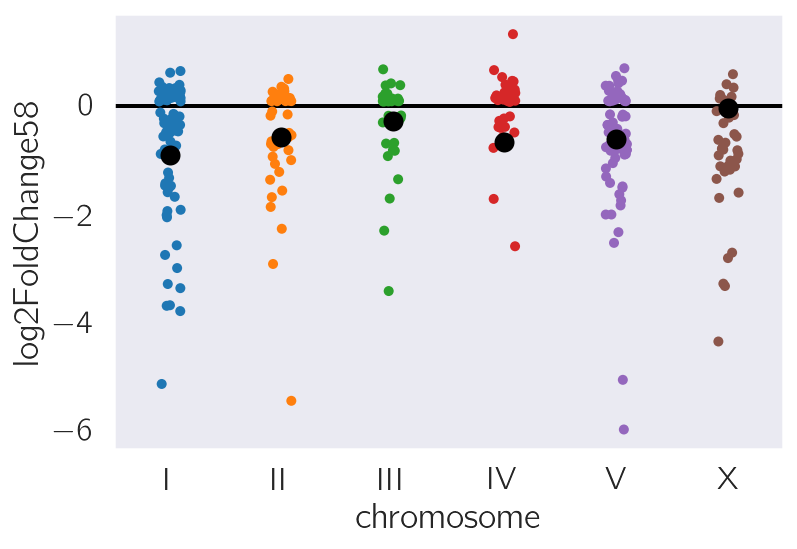

In [88]:
sig = (res.padj_58 < 0.05) & (res.padj_50 < 0.05) & (res.Sign == 'Same')
sns.stripplot(x='chromosome', y='log2FoldChange58', data=res[sig].rename(columns={'log2FoldChange_58': 'log2FoldChange58',
                                                                                  'chromosome_name': 'chromosome',
                                                                                  })
             )
sns.stripplot(x='chromosome', y='log2FoldChange58', data=res[sig].rename(columns={'log2FoldChange_58': 'log2FoldChange58',
                                                                                  'chromosome_name': 'chromosome',
                                                                                  }).groupby('chromosome').log2FoldChange58.apply(np.mean).reset_index(),
             size=10, color='black', jitter=False)
plt.axhline(0, color='black')

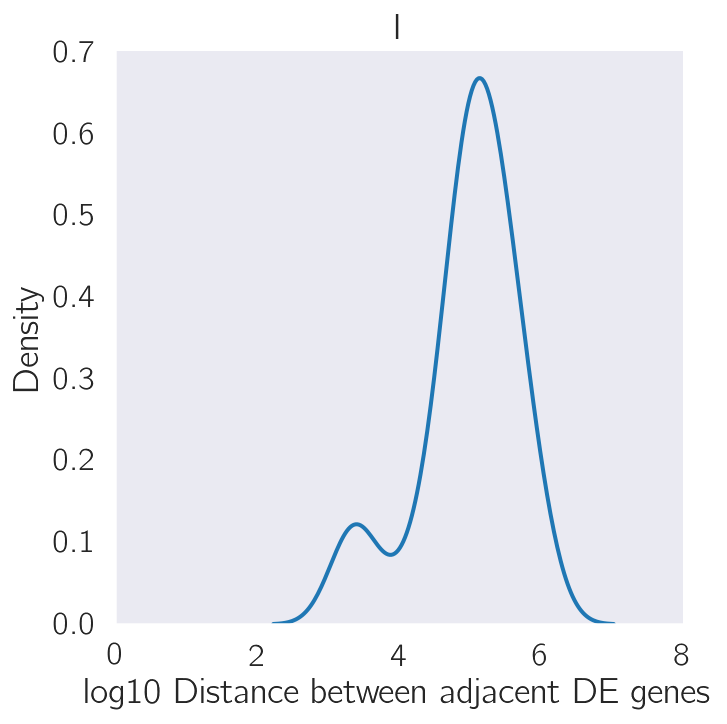

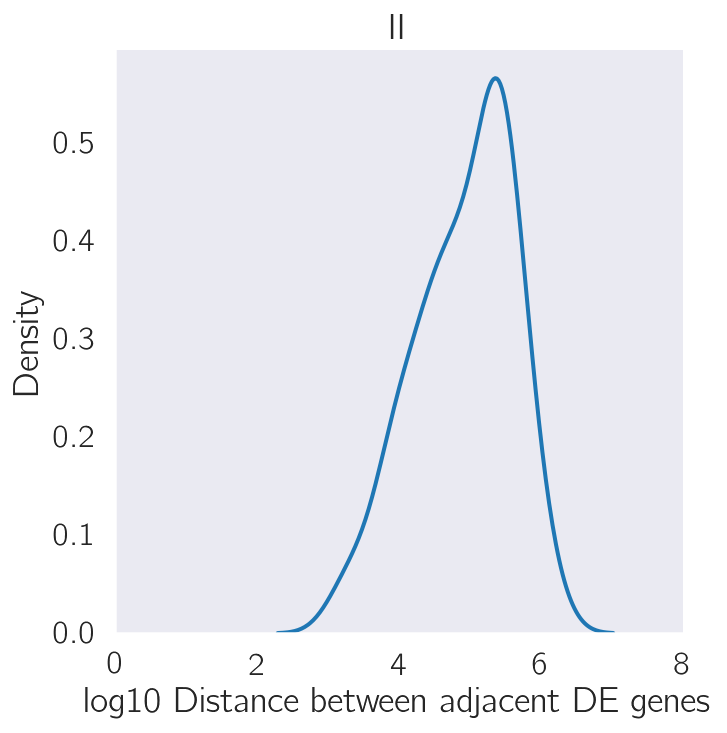

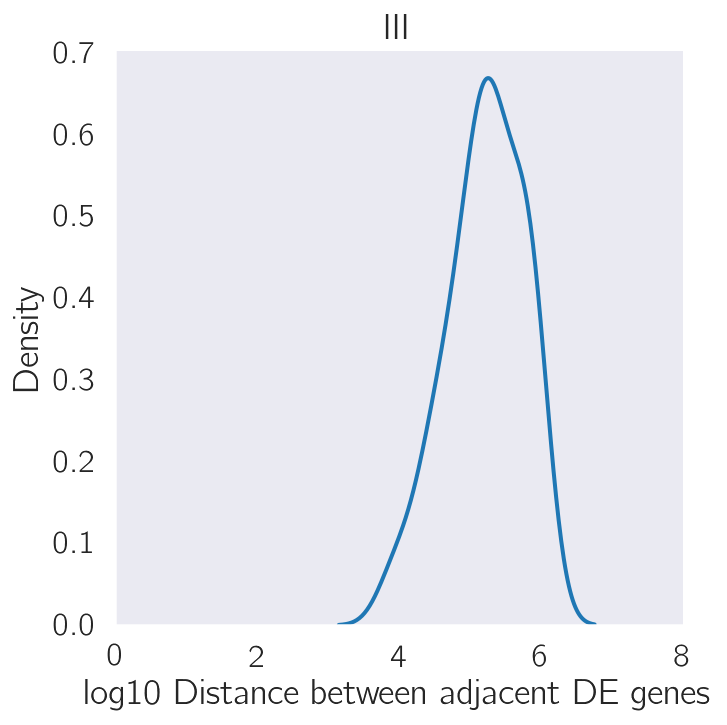

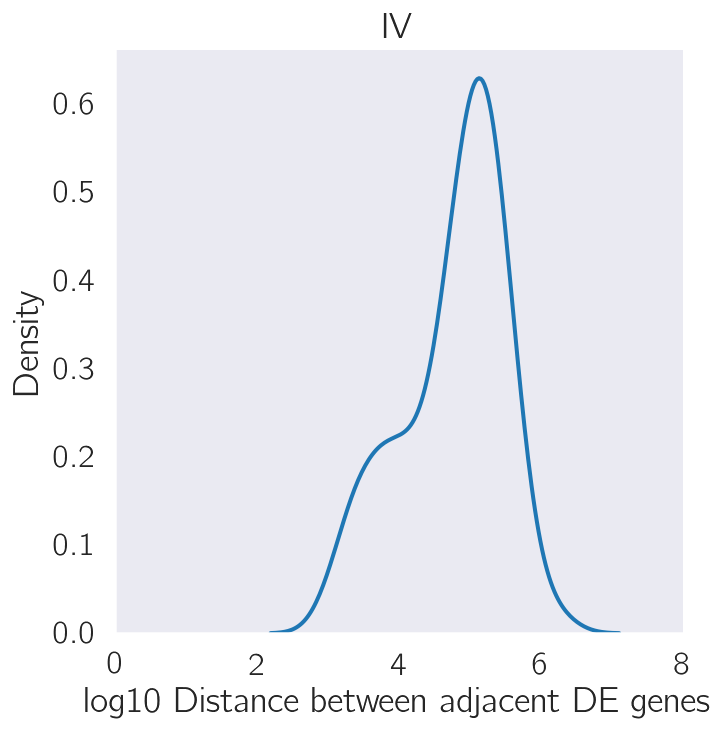

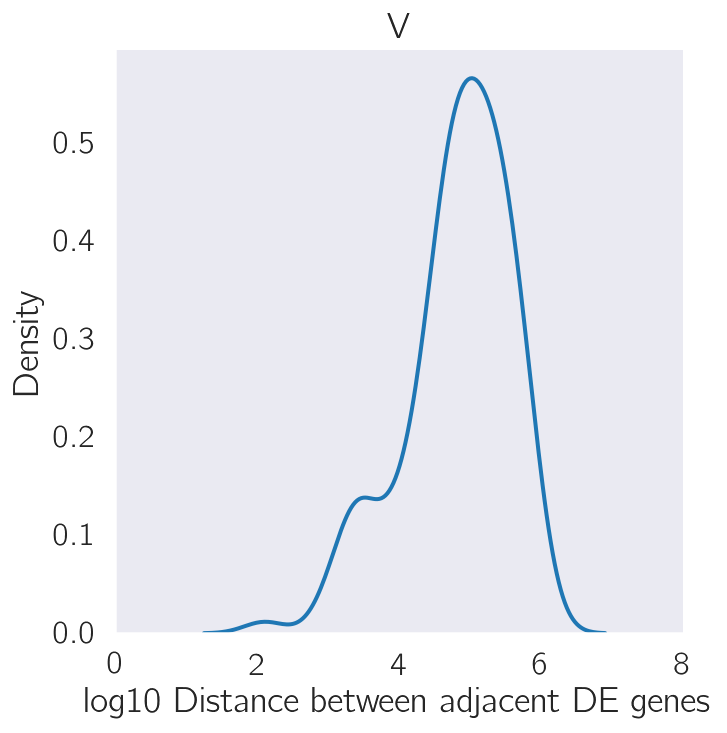

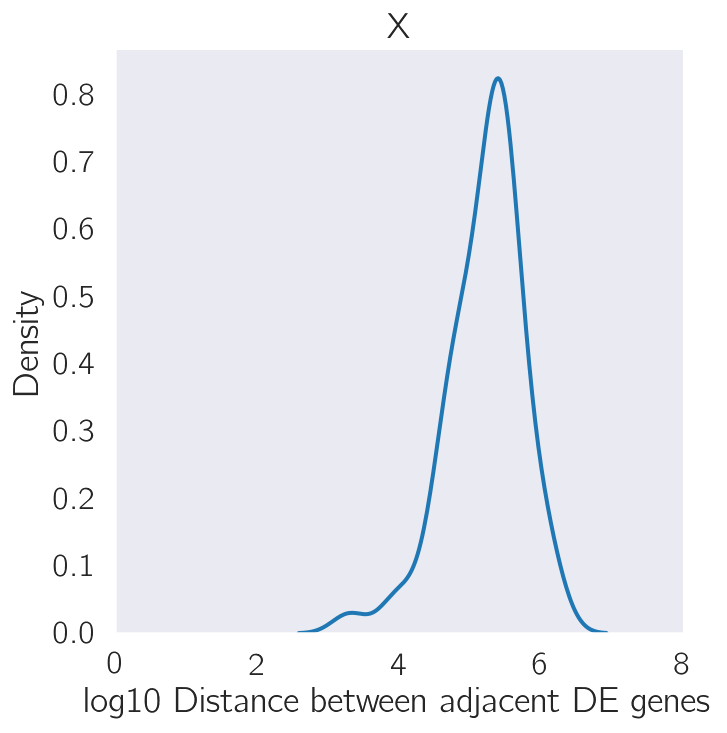

In [35]:
sel = (res.padj_58 < 0.05) & (res.Sign == 'Same')
tmp = res[sel].copy()
tmp['Diff'] = np.log10(tmp.sort_values(['chromosome_name', 'start_position']).groupby('chromosome_name').start_position.diff() + 1)
tmp['Chromosome'] = tmp.chromosome_name.values

for n, g in tmp.groupby('Chromosome'):
    sns.displot(g.Diff, kind='kde')
    plt.xlim(0, 8)
    plt.xlabel('log10 Distance between adjacent DE genes')
    plt.title(n)

In [36]:
stat = np.median

def bootstrap(stat=np.median):
    new = res.sample(n=len(tmp), replace=False).copy()
    new['Diff'] = np.log10(new.sort_values(['chromosome_name', 'start_position']).groupby('chromosome_name').start_position.diff() + 1)
    new = new[new.chromosome_name != 'MtDNA']
    return new.groupby('chromosome_name').Diff.median().reset_index()

boots = []
for i in range(10 ** 4):
    if i % 10 **3 == 0:
        print('Bootstrap', i, 'finished')
    boots += [bootstrap()]

boots = pd.concat(boots)

Bootstrap 0 finished
Bootstrap 1000 finished
Bootstrap 2000 finished
Bootstrap 3000 finished
Bootstrap 4000 finished
Bootstrap 5000 finished
Bootstrap 6000 finished
Bootstrap 7000 finished
Bootstrap 8000 finished
Bootstrap 9000 finished


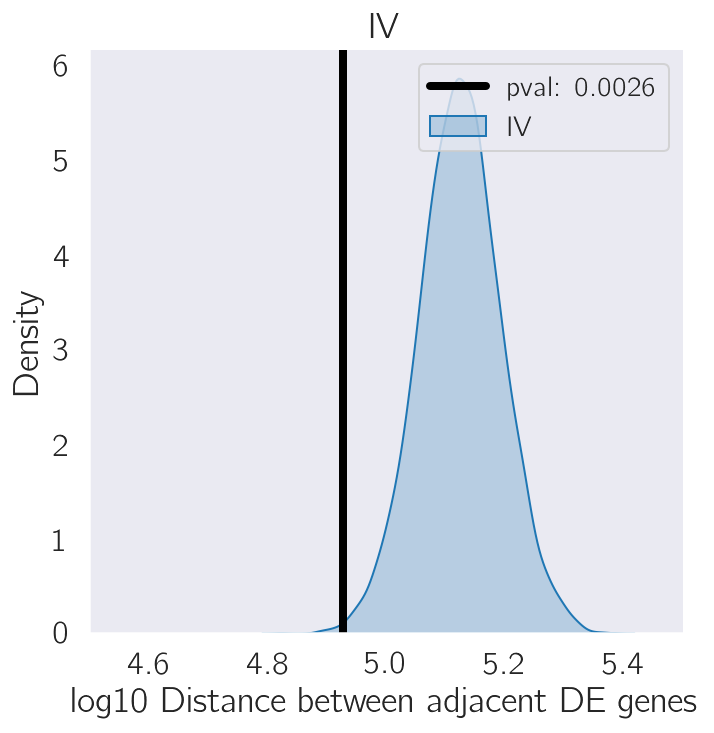

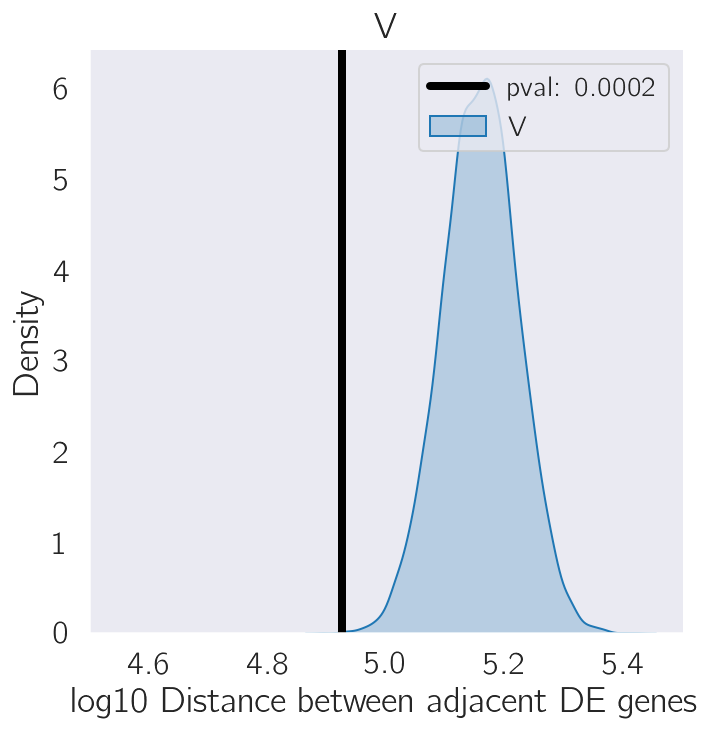

In [37]:
for n, g in boots.groupby('chromosome_name'):
    if n == 'MtDNA':
        continue
    obs = tmp[tmp.chromosome_name == n].Diff.median()
    pval = (g.Diff < obs).sum() / len(g)

    alpha = 0.05  # bonferroni correction

    if pval > alpha:
        continue

    sns.displot(g.Diff, label=n, kind='kde', fill=True)
    plt.axvline(obs, label='pval: {0:.2g}'.format(pval), lw=4, color='black')
    plt.legend()
    plt.xlim(4.5, 5.5)
    plt.xlabel('log10 Distance between adjacent DE genes')
    plt.title(n)

In [111]:
def calculate_pearson(dataframe, col, pval, shuffle=False, window_size=5):
    df = dataframe.copy()
    df.sort_values(['chromosome_name', 'start_position'], inplace=True)
    
    if pval is None:
        subset = [True] * len(df)
    else:
        subset = df[col] < pval

    corrs = []
    avg_poss = []
    chroms = []
    for n, g in df[subset].groupby('chromosome_name'):
        if shuffle is True:
            g = g.sample(frac=1)
        correlation = g.start_position.rolling(window_size).corr(g.log2FoldChange_58)
        avg_pos = g.start_position.rolling(window_size).mean()
        # store values:
        corrs += correlation.values.tolist()
        avg_poss += avg_pos.values.tolist()
        chroms += [n] * len(correlation)

    corr = pd.DataFrame([chroms, avg_poss, corrs]).T
    corr.columns = ['chromosome', 'pos', 'pearson']
    corr.pearson = corr.pearson.astype(np.float64)
    corr.pos = corr.pos.astype(np.float64)
    corr = corr.dropna()
    corr.set_index('pos', inplace=True)
    return corr

def get_corr_and_shuffle(col, pval, window=6):
    corr = calculate_pearson(res, col, pval, shuffle=False, window_size=window)

    # shuffled
    reps = 10 ** 3
    randoms = []
    for i in range(reps):
        tmp = calculate_pearson(res, col, pval, shuffle=True, window_size=window)
        tmp['rep'] = [i] * len(tmp)
        tmp.index = corr.index
        randoms +=  [tmp]
    shuffled = pd.concat(randoms)
    return corr, shuffled


def plot_corrs(corr, shuffled):
    """
    Given a dataframe `corr` containing sliding windows of pearson correlations,
    and a `shuffled` dataframe of correlations with N replicates, plot the correlations.
    """
    fig, ax = plt.subplots(figsize=(42, 16), ncols=3, nrows=2, sharey=True)

    i = 0
    for n, g in corr.groupby('chromosome'):
        y = i % 3
        x = int((i - y) / 3)
        
        rand5 = shuffled[shuffled.chromosome == n].dropna().groupby('pos').pearson.quantile(0.05).mean()
        rand95 = shuffled[shuffled.chromosome == n].dropna().groupby('pos').pearson.quantile(0.95).mean()

        sel = (g.pearson < rand5) | (g.pearson > rand95)
        ax[x, y].plot(g.pearson)
        ax[x, y].scatter(g[sel].index, g[sel].pearson, color='red', s=90, zorder=np.inf)
        ax[x, y].fill_between(g.index, rand5, rand95, color='gray', alpha=0.5)
        ax[x, y].set_title(n, fontsize=35)
        i += 1

(-1.0, 1.0)

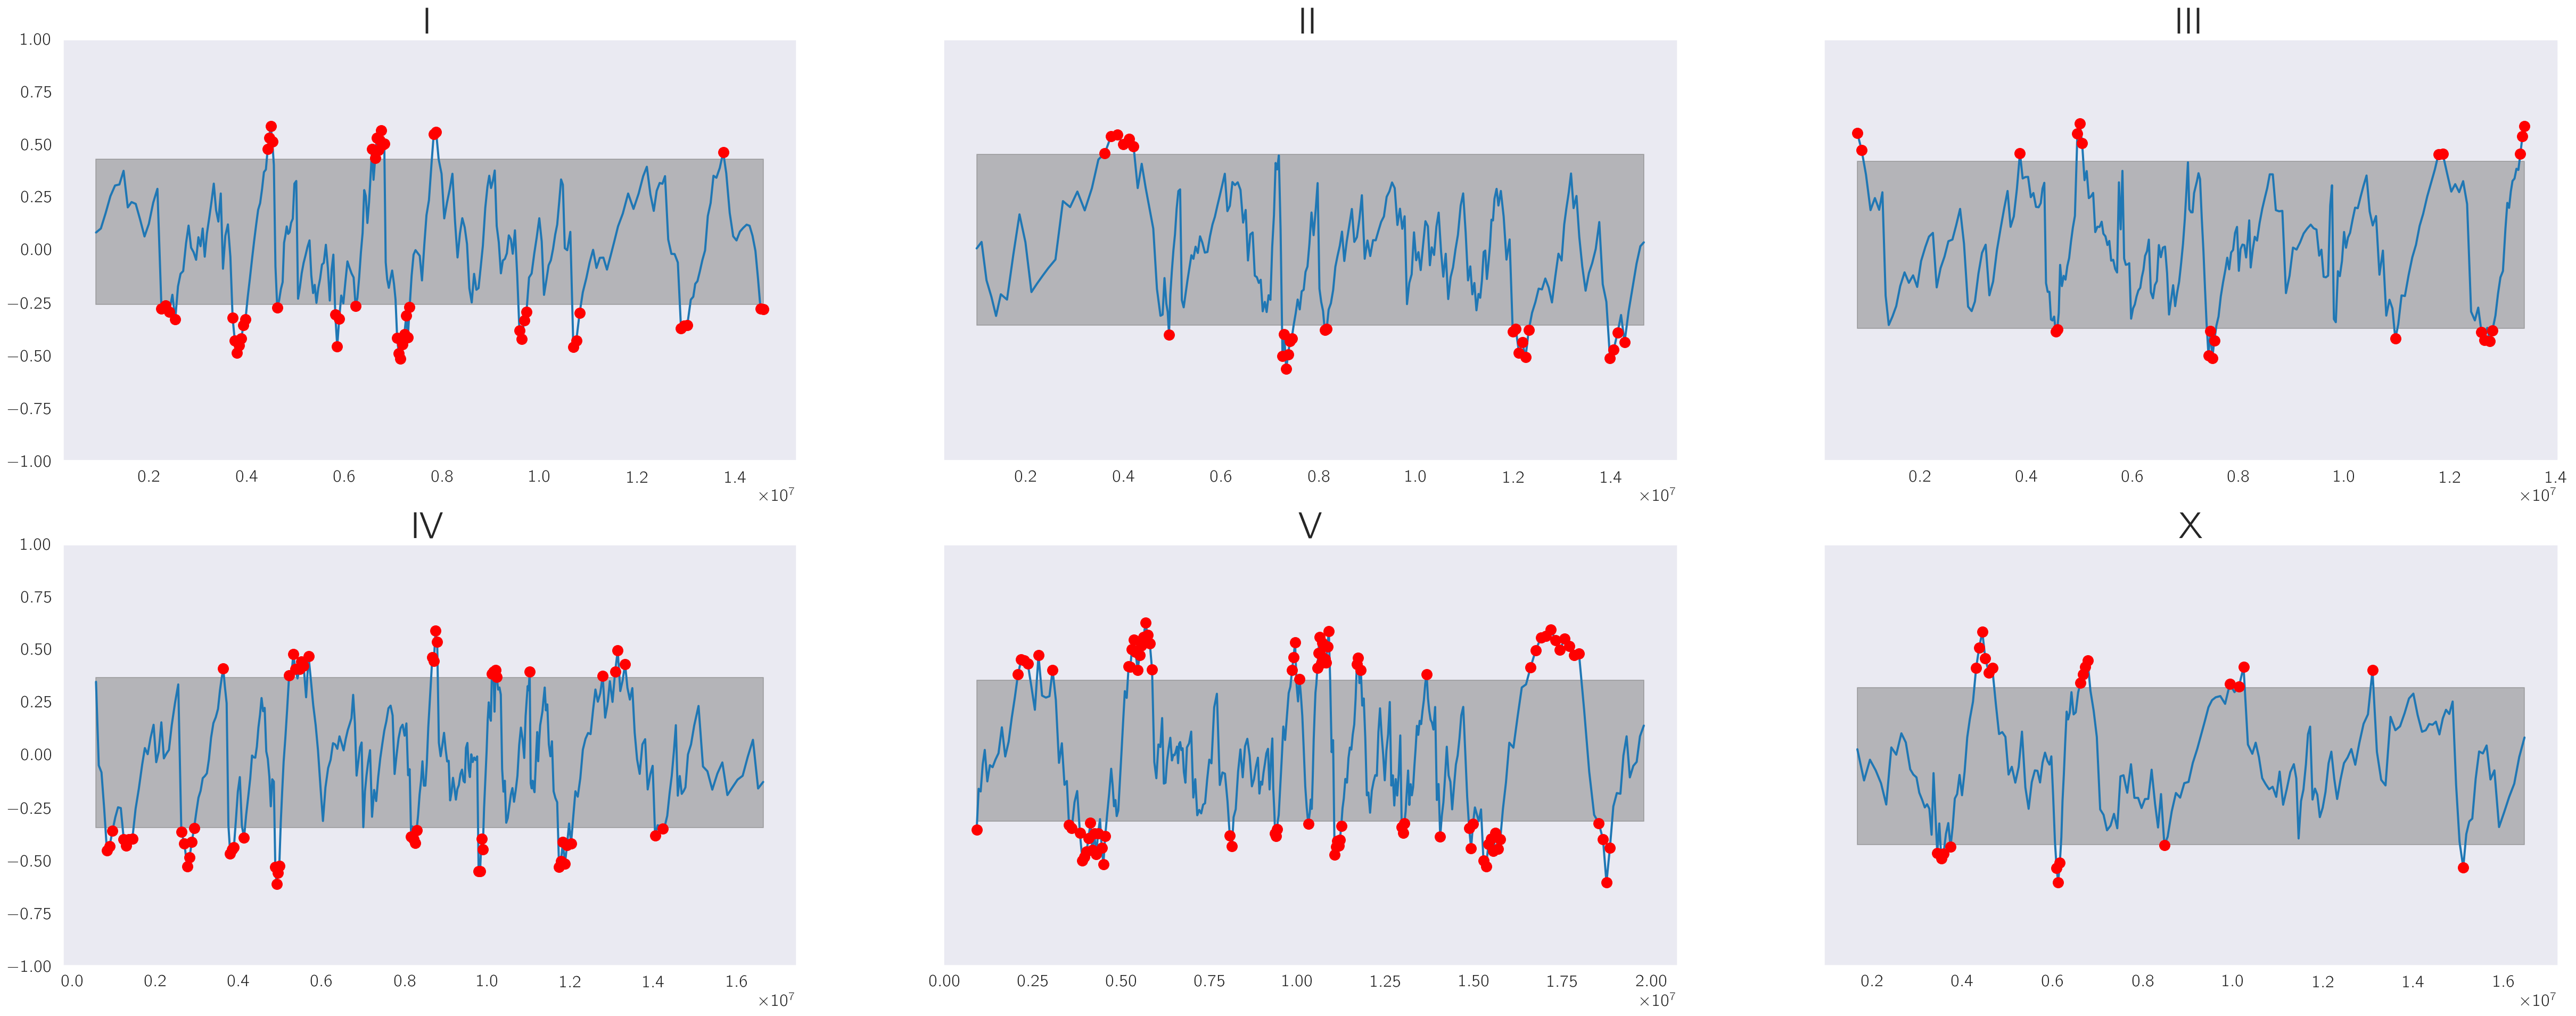

In [114]:
corr, shuffled = get_corr_and_shuffle('padj_50', pval = 0.05, window=20)
plot_corrs(corr, shuffled)
plt.ylim(-1, 1)

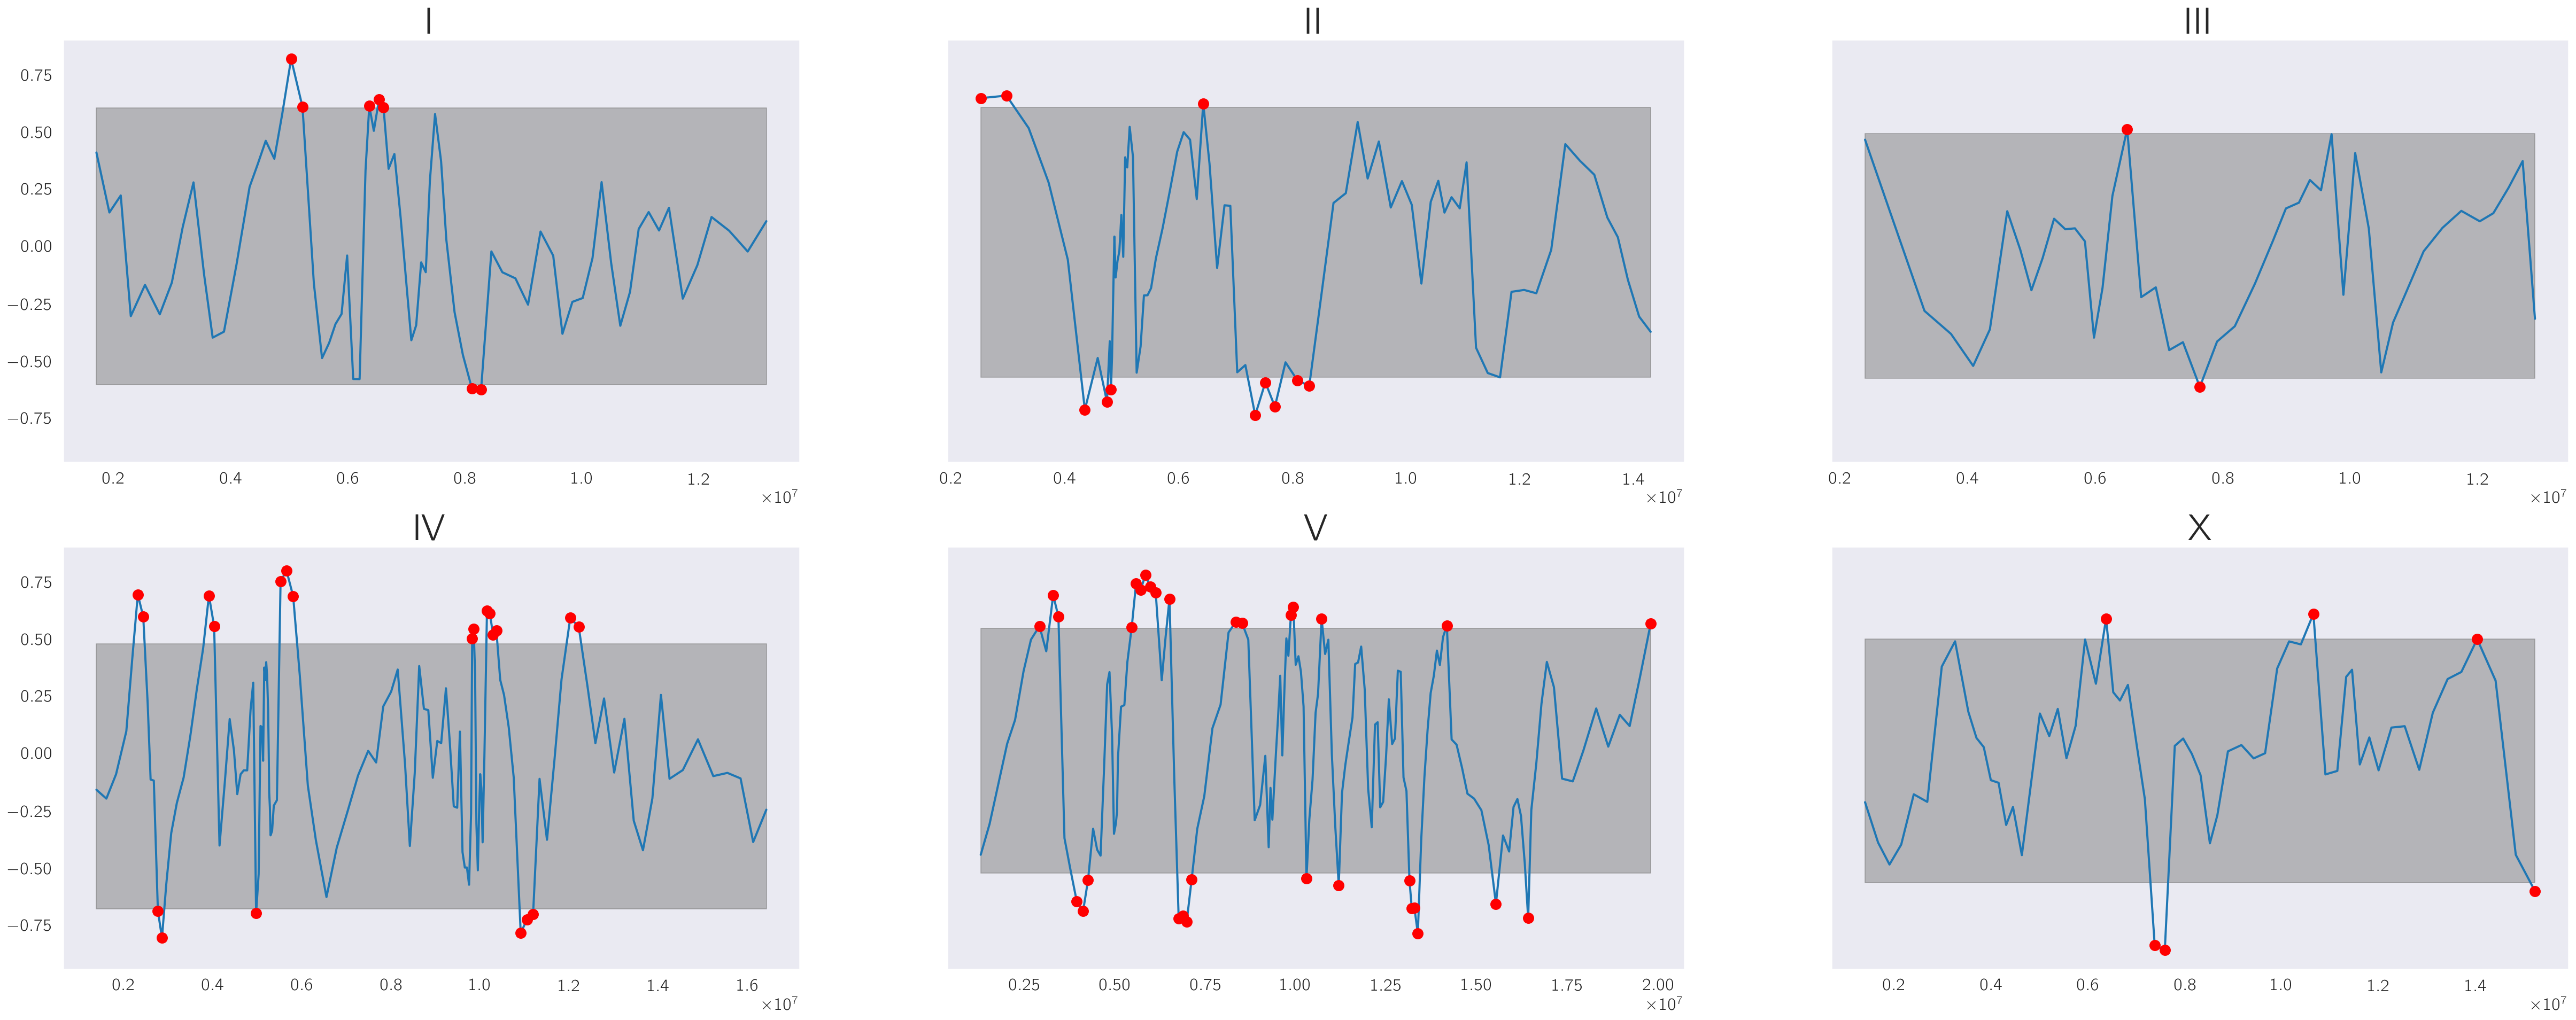

In [116]:
corr, shuffled = get_corr_and_shuffle('padj_58', 0.05, window=10)
plot_corrs(corr, shuffled)

# PQM-1 Enrichment

In [78]:
def calculate_enrichment(selection=None):
    if selection is None:
        selection = (res.padj_50 < 0.05) | (res.padj_58 < 0.05)
    
    selection = selection & (res.Sign == 'Same')
    
    group = 'pqm1'
    classII = [("Y")]
    null = res.groupby(group).Locus.count()
    obs = res[selection].groupby(group).Locus.count()
    fold = (obs / null * null.sum() / obs.sum())
    results = pd.DataFrame([null, obs, fold], index=['Null', 'Observed', 'Fold Change'])
    results = results.T
    results.Null = results.Null.astype(int)
    results.Observed = results.Observed.astype(int)
    print(results)

    # hypergeometric test:
    Total = null.sum()
    ClassII = null.reindex(classII).values[0]
    draws = obs.sum()
    ObsClassII = obs.reindex(classII).values[0]
    pval = scipy.stats.hypergeom.sf(ObsClassII, Total, ClassII, draws)
    
    # print message:
    message = '\n\nP-value associated with observing {0} class `{3}` genes out of {2} possible class 2 genes in this dataset: {1:.2g}'
    print(message.format(ObsClassII, pval, ClassII, classII[0]))

In [79]:
calculate_enrichment()

       Null  Observed  Fold Change
pqm1                              
N     11518      1145     0.877279
Y      2593       454     1.545122


P-value associated with observing 454 class `Y` genes out of 2593 possible class 2 genes in this dataset: 5.1e-26


In [86]:
for i in ['50', '58']:
    for j in ['down', 'up']:
        if j == 'up':
            direction = (res['log2FoldChange_' + i] > 0)
        else:
            direction = (res['log2FoldChange_' + i] < 0)
        print('Enrichment test for {0}-regulated genes at {1}hrs'.format(j, i))
        calculate_enrichment((res['padj_' + i] < 0.05) & direction)
        print('#################################################\n')

Enrichment test for down-regulated genes at 50hrs
       Null  Observed  Fold Change
pqm1                              
N     11518       470     1.022752
Y      2593        93     0.898938


P-value associated with observing 93 class `Y` genes out of 2593 possible class 2 genes in this dataset: 0.87
#################################################

Enrichment test for up-regulated genes at 50hrs
       Null  Observed  Fold Change
pqm1                              
N     11518       555     0.774425
Y      2593       323     2.001996


P-value associated with observing 323 class `Y` genes out of 2593 possible class 2 genes in this dataset: 3.5e-41
#################################################

Enrichment test for down-regulated genes at 58hrs
       Null  Observed  Fold Change
pqm1                              
N     11518       254      1.05129
Y      2593        42      0.77217


P-value associated with observing 42 class `Y` genes out of 2593 possible class 2 genes in this data

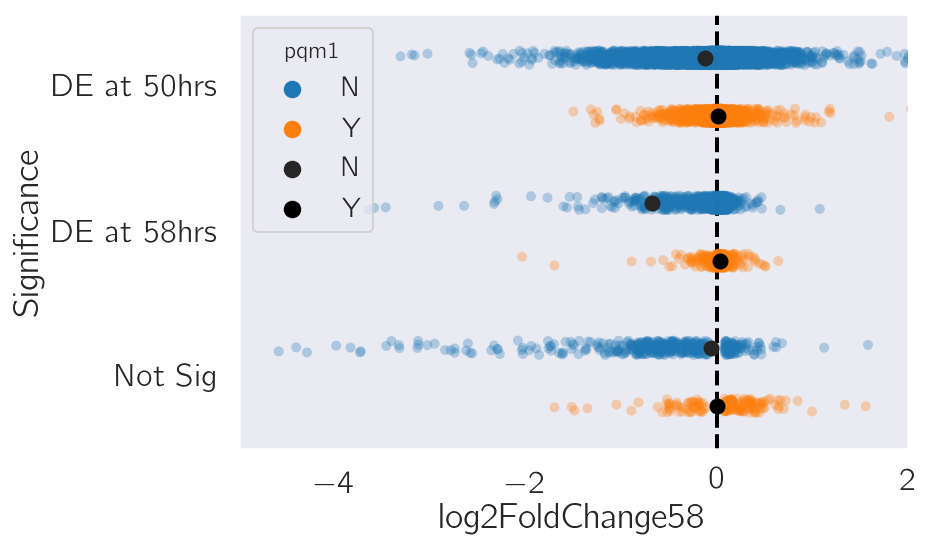

In [87]:
sns.stripplot(x='log2FoldChange58', y='Significance', hue='pqm1', data=res.rename(columns={'log2FoldChange_58': 'log2FoldChange58'}),
             dodge=True, alpha=0.3)
sns.stripplot(x='log2FoldChange58', y='Significance', hue='pqm1',
              data=res.rename(columns={'log2FoldChange_58': 'log2FoldChange58'}).groupby(['Significance', 'pqm1']).log2FoldChange58.apply(np.mean).reset_index(),
              size=8, color='black', alpha=1, dodge=True, jitter=False)
plt.xlim(-5, 2)
plt.axvline(0, ls='--', color='black')